In [52]:
import os
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from PIL import Image
import cv2

from pathlib import Path

import matplotlib.pyplot as plt

import h5py


In [11]:
def custom_json_to_label_map(json_path, img_height, img_width, category_mapping=None):
    """
    Convert your custom JSON format to pixel-wise label maps.
    
    Args:
        json_path: Path to your JSON file
        img_height: Height of the image
        img_width: Width of the image
        category_mapping: Dict mapping annotation 'name' to category ID
                         e.g., {'background': 0, 'class1': 1, 'class2': 2}
    
    Returns:
        label_map: numpy array of shape (height, width) with category IDs
        category_mapping: The category mapping used
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Initialize label map with zeros (background)
    label_map = np.zeros((img_height, img_width), dtype=np.uint8)
    
    # If no category mapping provided, create one automatically
    if category_mapping is None:
        all_names = set()
        for item in data:
            for ann_id, ann in item.items():
                if 'name' in ann:
                    all_names.add(ann['name'])
        category_mapping = {name: idx + 1 for idx, name in enumerate(sorted(all_names))}
        category_mapping['background'] = 0
        print("Auto-generated category mapping:", category_mapping)
    
    # Process each item in the list
    for item in data:
        # Each item is a dict with annotation IDs as keys
        for ann_id, ann in item.items():
            # Get category ID from name
            category_name = ann.get('name', 'unknown')
            category_id = category_mapping.get(category_name, 0)
            
            # Get coordinates
            x_coords = ann.get('x', [])
            y_coords = ann.get('y', [])
            
            if len(x_coords) > 0 and len(y_coords) > 0:
                # Create polygon points (x, y pairs)
                points = np.array([[int(x), int(y)] for x, y in zip(x_coords, y_coords)], 
                                dtype=np.int32)
                
                # Fill polygon on label map
                cv2.fillPoly(label_map, [points], category_id)
                
                print(f"Processed annotation {ann_id}: {category_name} (ID: {category_id}), {len(points)} points")
    
    return label_map, category_mapping


def batch_convert_jsons(json_dir, output_dir, img_height, img_width, category_mapping=None):
    """
    Convert multiple JSON files to label maps.
    """
    import os
    from pathlib import Path
    
    os.makedirs(output_dir, exist_ok=True)
    
    json_files = list(Path(json_dir).glob("*.json"))
    
    for json_file in json_files:
        label_map, mapping = custom_json_to_label_map(
            str(json_file),
            img_height,
            img_width,
            category_mapping
        )
        
        # Save with same name but .png extension
        output_path = os.path.join(output_dir, json_file.stem + '_label.png')
        Image.fromarray(label_map).save(output_path)
        print(f"Saved {output_path}")
    
    # Save mapping
    with open(os.path.join(output_dir, 'category_mapping.json'), 'w') as f:
        json.dump(mapping, f, indent=2)

In [26]:
root = Path("0040")
root_ = Path("0040/Train")

json_files = sorted(list(root.glob("*.json")))

# Get all PNG files
all_png_files = sorted(list(root_.glob("*.png")))

# Separate into three lists
original_images = []
processed_images = []
masked_images = []

for png_file in all_png_files:
    if '_masked' in png_file.stem:
        masked_images.append(png_file)
    elif '_processed' in png_file.stem:
        processed_images.append(png_file)
    else:
        original_images.append(png_file)

print(f"JSON files: {len(json_files)}")
print(f"Original images: {len(original_images)}")
print(f"Processed images: {len(processed_images)}")
print(f"Masked images: {len(masked_images)}")

# Verify they match
print(f"\nAll counts equal: {len(json_files) == len(original_images) == len(processed_images) == len(masked_images)}")

JSON files: 595
Original images: 595
Processed images: 595
Masked images: 595

All counts equal: True


In [45]:
img_height = 504  # CHANGE to your image height
img_width = 663 

labels = []
masks = []
raws = []
for json_file,masked_image,original_image in zip(json_files,masked_images,original_images):

    label_map, mapping = custom_json_to_label_map(
    json_file,
    img_height=img_height,
    img_width=img_width,
    category_mapping=None  # Auto-generate from 'name' field
    )

    labels.append(label_map)


    mask = np.array(Image.open(masked_image))
    masks.append(mask)

    raw = np.array(Image.open(original_image))
    raws.append(raw)

labels_np = np.stack(labels)
masks_np = np.stack(masks)
raws_np = np.stack(raws)


Auto-generated category mapping: {'0194-0302-0428': 1, 'background': 0}
Processed annotation 0194-0302-0428: 0194-0302-0428 (ID: 1), 38 points
Auto-generated category mapping: {'0195-0302-0427': 1, 'background': 0}
Processed annotation 0195-0302-0427: 0195-0302-0427 (ID: 1), 12 points
Auto-generated category mapping: {'0196-0302-0427': 1, 'background': 0}
Processed annotation 0196-0302-0427: 0196-0302-0427 (ID: 1), 12 points
Auto-generated category mapping: {'0197-0302-0427': 1, 'background': 0}
Processed annotation 0197-0302-0427: 0197-0302-0427 (ID: 1), 18 points
Auto-generated category mapping: {'0198-0302-0427': 1, 'background': 0}
Processed annotation 0198-0302-0427: 0198-0302-0427 (ID: 1), 16 points
Auto-generated category mapping: {'0199-0303-0426': 1, 'background': 0}
Processed annotation 0199-0303-0426: 0199-0303-0426 (ID: 1), 20 points
Auto-generated category mapping: {'0200-0304-0427': 1, 'background': 0}
Processed annotation 0200-0304-0427: 0200-0304-0427 (ID: 1), 139 point

In [46]:
# 1. Basic statistics
print("=== Shape Comparison ===")
print(f"Labels shape: {labels_np.shape}")
print(f"Masks shape: {masks_np.shape}")
print(f"Shapes match: {labels_np.shape == masks_np.shape}")

# 2. Value ranges
print("\n=== Value Ranges ===")
print(f"Labels - min: {labels_np.min()}, max: {labels_np.max()}, unique: {np.unique(labels_np)}")
print(f"Masks - min: {masks_np.min()}, max: {masks_np.max()}, unique: {np.unique(masks_np)}")

# 3. Check if they're identical
print("\n=== Exact Match ===")
print(f"Arrays identical: {np.array_equal(labels_np, masks_np)}")

# 4. Normalize masks if needed (masks might be 0-255, labels are 0-1)
if masks_np.max() > 1:
    masks_np_binary = (masks_np > 0).astype(np.uint8)
    labels_np_binary = (labels_np > 0).astype(np.uint8)
    print(f"Binary match (after normalizing mask): {np.array_equal(labels_np_binary, masks_np_binary)}")


=== Shape Comparison ===
Labels shape: (595, 504, 663)
Masks shape: (595, 504, 663)
Shapes match: True

=== Value Ranges ===
Labels - min: 0, max: 9, unique: [0 1 2 3 4 5 6 7 8 9]
Masks - min: 0, max: 255, unique: [  0 255]

=== Exact Match ===
Arrays identical: False
Binary match (after normalizing mask): True


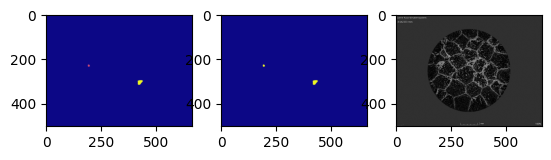

In [ ]:
fig, axs = plt.subplots(1,3)

slice = 20

axs[0].imshow(labels_np[slice,::],cmap="plasma")
axs[1].imshow(masks_np[slice,::],cmap="plasma")
axs[2].imshow(raws_np[slice,::],cmap="gray")

In [53]:



with h5py.File(f"{root.name}.h5","w") as f:
    f.create_dataset("raw",data=raws_np,compression="gzip")
    f.create_dataset("masks",data=masks_np,compression="gzip")
